## Multi gpu로 학습하는 게 중요한 이유
옛날과 비교해서 지금은 데이터의 양도 늘어나고 학습하는 시간이 오래 걸리기 때문이다.

오늘날의 딥러닝은 엄청난 데이터와의 싸움이다. 그래서 연구는 장비빨이라는 말도 있긴 하다(GPU 확보)...

## 개념 정리
- Single vs Mulit => 1개 vs 2개 이상
- GPU vs Node => Node는 시스템(컴퓨터), Node의 GPU를 사용한다.
- Single Node Single GPU => 한 대의 컴퓨터에서 한 개의 GPU사용
- Single Node Multi GPU => 한 대의 컴퓨터에 여러 개의 GPU 사용
- Multi Node Multi GPU => 여러 대의 컴퓨터에 여러 개의 GPU 사용

## Model parallel
- 다중 GPU에 학습을 분산하는 두 가지 방법 => 모델을 나누기 / 데이터를 나누기
- 모델을 나누는 것은 생각보다 예전부터 썼다(alexnet)
- 모델의 병목, 파이프라인의 어려움 등으로 인해 모델 병렬화는 고난이도 과제이다.

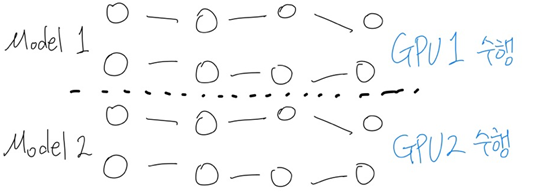

아래 그림의 동그라미 부분처럼 모델을 각각 다른 GPU로 보내는 것이 모델 나누기이다.

ex) .to(device) 했던 것 처럼!
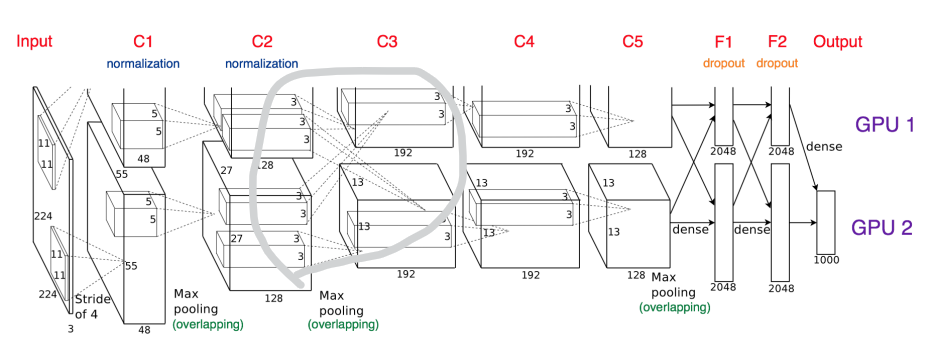

In [ ]:
# Example
class ModelParallelResNet50(ResNet):
    def __init__(self, *args, **kwargs):
        super(ModelParallelResNet50, self).__init__(
            Bottleneck, [3, 4, 6, 3], num_classes=num_classes, *args, **kwargs)
        
        self.seq1 = nn.Sequential(
            self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2
        ).to('cuda:0')  # 첫 번째 모델을 cuda 0에 할당

        self.seq2 = nn.Sequential(
            self.layer3, self.layer4, self.avgpool,)
        ).to('cuda:1')  # 두 번째 모델을 cuda 1에 할당

        self.fc.to('cuda:1')

    def forward(self, x):
        x = self.seq2(self.seq1(x).to('cuda:1'))
        return self.fc(x.view(x.size(0), -1))
        # 두 모델을 연결하기       

# Data Parallel
- 데이터를 나눠 GPU에 할당 후 결과의 평균을 취하는 방법
- minibatch 수식과 유사한데 한 번에 여러 GPU에서 수행

- PyTorch에서는 아래 두 가지 방식을 제공
> 1. DataParallel,
> 2. DistributedDataParallel

- 1. DataParallel : 단순히 데이터를 분배한 후 평균을 취함 => GPU 사용 불균형 문제 발생, Batch 사이즈 감소 (한 GPU가 병목), GIL

- 2. DistributedDataParallel : 각 CPU마다 process 생성하여 개별 GPU에 할당 => 기본적으로 DataParallel로 하나 개별적으로 연산의 평균을 냄

In [ ]:
# Example

parallel_model = torch.nn.DataParllel(model) # 한 줄 끝

# or
# Distributed DataParallel은 DataParallel 보다 더 귀찮은 과정을 거친다.
train_sampler = torch.utils.data.distributed.DistributedSampler(train_data)
shuffle = False
pin_memory = True # 메모리에 데이터를 올리는 절차를 간소화 하는 것?
trainloader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=False,
                                          pin_memory=pin_memory, num_workers=3,
                                          sampler = train_sampler)

# *Reference*
1.
[Pytorch Lightning Multi GPU 학습](https://pytorch-lightning.readthedocs.io/en/stable/advanced/multi_gpu.html#multi-gpu-training)
- DDP는 병렬적으로 계산을 수행해서 optimizer가 각각 GPU에서 weight를 업데이트 한다.

- PyTorch에서 DataParallel을 사용하면 안 되는 이유 설명함.

2.
[DDP 튜토리얼](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html)

world_size : gpu 개수 * node(시스템) 개수